In [1]:
from pydataset import data
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')
import seaborn as sns
import numpy as np

In [2]:
df = data('mcycle')

In [3]:
df.head(5)

,times,accel
1,2.4,0.0
2,2.6,-1.3
3,3.2,-2.7
4,3.6,0.0
5,4.0,-2.7


In [4]:
df.count()

times    133
accel    133
dtype: int64

accel variable notes the acceleration of head certain time after the impact in variable times. head acceleration is the predictor variable y and 

In [5]:
y = df['accel']
x = df['times']

In [6]:
print(x)

1       2.4
2       2.6
3       3.2
4       3.6
5       4.0
6       6.2
7       6.6
8       6.8
9       7.8
10      8.2
11      8.8
12      8.8
13      9.6
14     10.0
15     10.2
16     10.6
17     11.0
18     11.4
19     13.2
20     13.6
21     13.8
22     14.6
23     14.6
24     14.6
25     14.6
26     14.6
27     14.6
28     14.8
29     15.4
30     15.4
31     15.4
32     15.4
33     15.6
34     15.6
35     15.8
36     15.8
37     16.0
38     16.0
39     16.2
40     16.2
41     16.2
42     16.4
43     16.4
44     16.6
45     16.8
46     16.8
47     16.8
48     17.6
49     17.6
50     17.6
51     17.6
52     17.8
53     17.8
54     18.6
55     18.6
56     19.2
57     19.4
58     19.4
59     19.6
60     20.2
61     20.4
62     21.2
63     21.4
64     21.8
65     22.0
66     23.2
67     23.4
68     24.0
69     24.2
70     24.2
71     24.6
72     25.0
73     25.0
74     25.4
75     25.4
76     25.6
77     26.0
78     26.2
79     26.2
80     26.4
81     27.0
82     27.2
83     27.2
84  

Text(0, 0.5, 'accel')

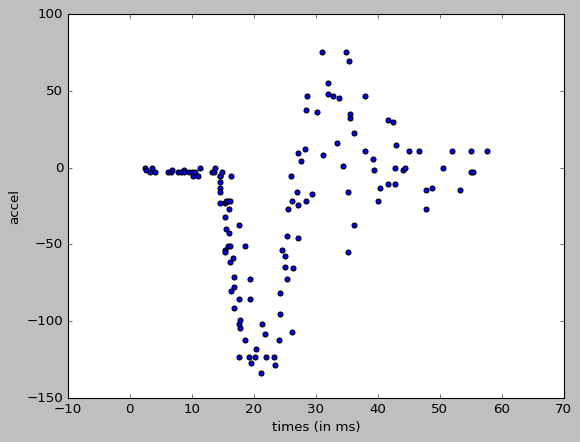

In [7]:
plt.scatter(x, y)
plt.xlabel('times (in ms)')
plt.ylabel('accel')

# K-fold cross validation function 

we make k folds 

choose 1 as test and rest k-1 as train then find MSE

repeat this for k=1 to k=k and find k values of MSE

MSE_average = 1/k(Sum of all MSE)

In [8]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [9]:
def K_fold(k, X, y, model_class, metric_fn = mean_squared_error):

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = model_class()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        score = metric_fn(y_test, y_pred)
        scores.append(score)

    return scores


# 1) $\textit{m}th$ Degree polynomial fit

we fit polynomials with degree 1 to 10 and run the k-fold CV for every n=1 to 10 and choose one with lower MSE score

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

In [11]:
X = df['times'].values.reshape(-1, 1)
y = df['accel'].values

degrees = range(1, 10)  # Try degrees 1 to 10
avg_mse_KFold = []

In [12]:
for degree in degrees:
    model = PolynomialFeatures(degree=degree)
    X_polynomial = model.fit_transform(X)
    fold_mse_score = K_fold(5, X_polynomial, y, model_class= LinearRegression)
    avg_mse = np.mean(fold_mse_score)
    avg_mse_KFold.append(avg_mse)

In [13]:
avg_mse_KFold

[np.float64(2215.3622824016984),
 np.float64(2101.3199989525756),
 np.float64(1645.5212167638078),
 np.float64(1679.0676207739093),
 np.float64(1238.0434065450124),
 np.float64(1204.684947087048),
 np.float64(1382.0274615366961),
 np.float64(1134.5159217367702),
 np.float64(1389.2427446055904)]

In [14]:
best_index = np.argmin(avg_mse_KFold)
best_index

np.int64(7)

7th degree polynomial has lowest K-fold CV score.

In [15]:
# Degrees started from 1, so:
best_degree = degrees[best_index-1]
best_degree

7

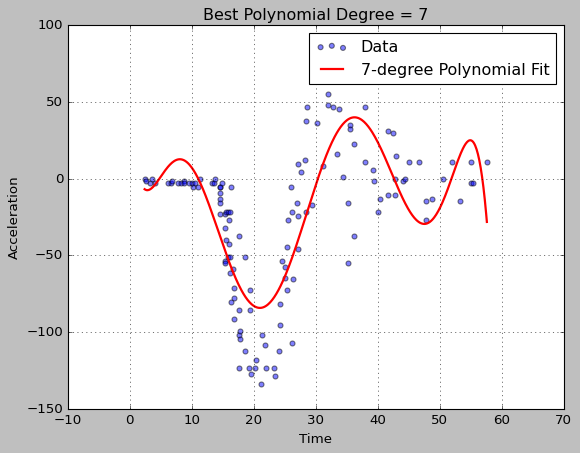

In [16]:
# Now create the best model
best_poly = PolynomialFeatures(degree=best_degree)
X_poly_best = best_poly.fit_transform(X)

best_model = LinearRegression().fit(X_poly_best, y)
X_plot = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
X_plot_poly = best_poly.transform(X_plot)
y_plot = best_model.predict(X_plot_poly)

# Plot original data and fitted curve
plt.scatter(X, y, label='Data', alpha=0.5)
plt.plot(X_plot, y_plot, color='red', label=f'{best_degree}-degree Polynomial Fit', linewidth=2)
plt.title(f'Best Polynomial Degree = {best_degree}')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.legend()
plt.grid(True)
plt.show()

# 2) Non-parametric Regression

## My choice of functional form is:  $\alpha$ + $\beta$ Sin(x/$\gamma$) 

where $\alpha$, $\beta$, $\gamma$ are the 3 parameters

In [17]:
from numpy.linalg import lstsq
from scipy import stats

In [18]:
t = df['times'].values
a = df['accel'].values

Parameter estimates and significance:
  a = -21.7008 ± 3.0558   (t = -7.10,  p ≈ 7.226e-11)
  b = 50.7443 ± 4.5934   (t = 11.05,  p ≈ 0.000e+00)
  c = 4.4252 ± 0.0547   (t = 80.84,  p ≈ 0.000e+00)


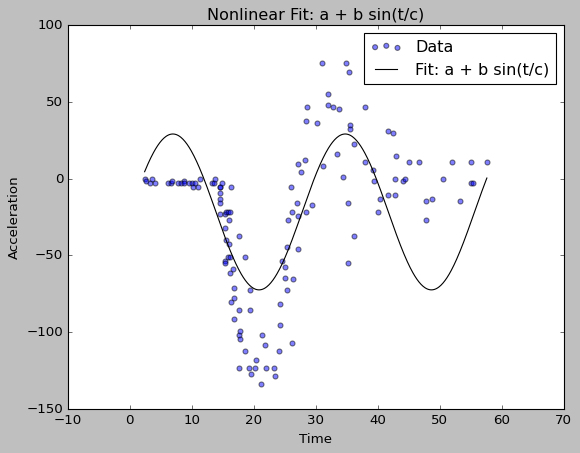

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats

# Load data
t = df['times'].values
a_obs = df['accel'].values

# Define the nonlinear model
def model(t, a, b, c):
    return a + b * np.sin(t / c)

# Initial guess [a, b, c]
p0 = [0, 10, 5]

# Fit the model
params, pcov = curve_fit(model, t, a_obs, p0=p0, maxfev=1000)
stderr = np.sqrt(np.diag(pcov))
a, b, c = params

# Compute t-stats and p-values
dof = len(a_obs) - len(params)
t_stats = params / stderr
p_vals = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=dof))

# Report
print("Parameter estimates and significance:")
for name, val, err, tval, pval in zip(['a', 'b', 'c'], params, stderr, t_stats, p_vals):
    print(f"  {name} = {val:.4f} ± {err:.4f}   (t = {tval:.2f},  p ≈ {pval:.3e})")

# Plot
t_plot = np.linspace(t.min(), t.max(), 500)
a_fit = model(t_plot, *params)

plt.scatter(t, a_obs, alpha=0.5, label='Data')
plt.plot(t_plot, a_fit, color='black', label='Fit: a + b sin(t/c)')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Nonlinear Fit: a + b sin(t/c)')
plt.legend()
plt.show()

### The one with 5 paramters might fit better.

$a + bSin(x/c) + dCos(x/e)$

Parameter estimates and significance:
  a = -16.6768 ± 2.8427   (t = -5.87,  p ≈ 3.581e-08)
  b = 35.0340 ± 5.2680   (t = 6.65,  p ≈ 7.663e-10)
  c = 4.2201 ± 0.0800   (t = 52.76,  p ≈ 0.000e+00)
  d = 30.5599 ± 5.1019   (t = 5.99,  p ≈ 1.987e-08)
  e = 6.9297 ± 0.2449   (t = 28.29,  p ≈ 0.000e+00)


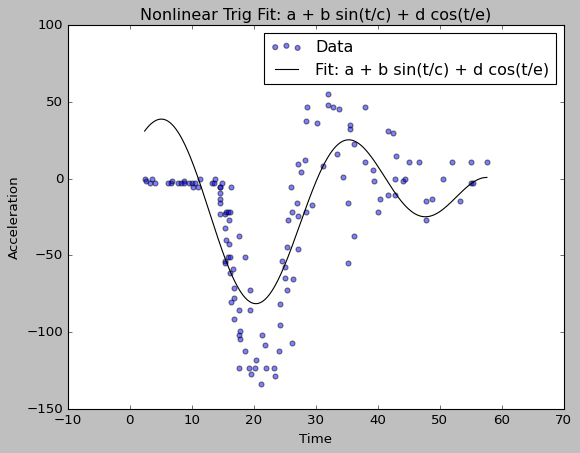

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats

t = df['times'].values
a_obs = df['accel'].values

# Define the model
def model(t, a, b, c, d, e):
    return a + b * np.sin(t / c) + d * np.cos(t / e)

# Initial guess [a, b, c, d, e]
p0 = [0, 10, 5, 10, 5]

# Fit model with curve_fit
params, pcov = curve_fit(model, t, a_obs, p0=p0, maxfev=10000)
stderr = np.sqrt(np.diag(pcov))
a, b, c, d, e = params

# Compute t-stats and p-values
dof = len(a_obs) - len(params)
t_stats = params / stderr
p_vals = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=dof))

# Report
print("Parameter estimates and significance:")
for name, val, err, tval, pval in zip(['a', 'b', 'c', 'd', 'e'], params, stderr, t_stats, p_vals):
    print(f"  {name} = {val:.4f} ± {err:.4f}   (t = {tval:.2f},  p ≈ {pval:.3e})")

# Plotting the fitted curve
t_plot = np.linspace(t.min(), t.max(), 500)
a_fit = model(t_plot, *params)

plt.scatter(t, a_obs, alpha=0.5, label='Data')
plt.plot(t_plot, a_fit, color='black', label='Fit: a + b sin(t/c) + d cos(t/e)')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Nonlinear Trig Fit: a + b sin(t/c) + d cos(t/e)')
plt.legend()
plt.show()

# 3)Kernel Regression

I use gaussian kernel as it is most popular one.

In [21]:
import numpy as np
import matplotlib.pyplot as plt

t_train = df['times'].values
a_train = df['accel'].values

# Gaussian kernel function (standard)
def gaussian_kernel(u):
    return np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)

# Nadaraya-Watson estimator
def kernel_regression(t_train, a_train, t_eval, h):
    y_pred = np.zeros_like(t_eval)
    
    for j, t0 in enumerate(t_eval):
        u = (t0 - t_train) / h
        weights = gaussian_kernel(u)
        y_pred[j] = np.sum(weights * a_train) / np.sum(weights)
        
    return y_pred

In [22]:
# Evaluation grid
t_grid = np.linspace(t_train.min(), t_train.max(), 500)

# Choose bandwidth
h = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3]  

# Run kernel regression
for bandwidth in h:
    a_pred = kernel_regression(t_train, a_train, t_grid, bandwidth)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_index, test_index in kf.split(t_train):
        X_train, X_test = t_train[train_index], t_train[test_index]
        y_train, y_test = a_train[train_index], a_train[test_index]

        # Make predictions on the test set using kernel regression
        y_pred = kernel_regression(X_train, y_train, X_test, bandwidth)

        score = mean_squared_error(y_test, y_pred)
        scores.append(score)

    print(f"Bandwidth: {bandwidth}, Mean CV MSE: {np.mean(scores):.4f}")

    


Bandwidth: 0.25, Mean CV MSE: 864.5287
Bandwidth: 0.5, Mean CV MSE: 713.3646
Bandwidth: 0.75, Mean CV MSE: 650.1124
Bandwidth: 1, Mean CV MSE: 637.9380
Bandwidth: 1.25, Mean CV MSE: 645.2663
Bandwidth: 1.5, Mean CV MSE: 663.0502
Bandwidth: 1.75, Mean CV MSE: 688.6108
Bandwidth: 2, Mean CV MSE: 720.1973
Bandwidth: 2.5, Mean CV MSE: 794.7179
Bandwidth: 3, Mean CV MSE: 876.2440


By K-Fold CV, we have lowest MSE for h = 1

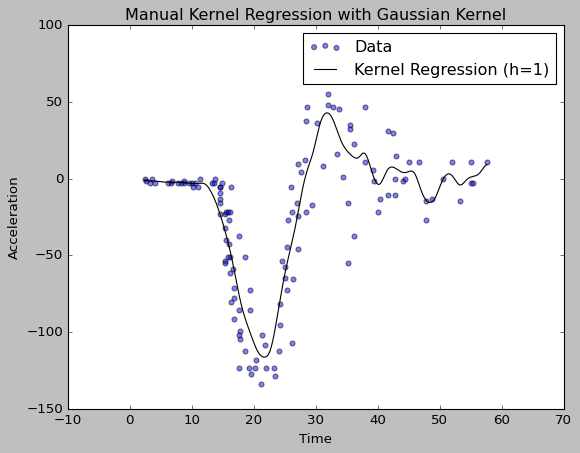

In [23]:
h = 1

# Run kernel regression
a_pred = kernel_regression(t_train, a_train, t_grid, h)

# Plot
plt.scatter(t_train, a_train, alpha=0.5, label='Data')
plt.plot(t_grid, a_pred, color='black', label=f'Kernel Regression (h={h})')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Manual Kernel Regression with Gaussian Kernel')
plt.legend()
plt.show()

In [24]:
def compute_smoother_trace(t_train, h):
    n = len(t_train)
    trace = 0.0
    for i in range(n):
        u = (t_train[i] - t_train) / h
        weights = gaussian_kernel(u)
        weights /= np.sum(weights)
        trace += weights[i]  # diagonal element S_ii
    return trace

### Degree of freedom

In [25]:
trace_S = compute_smoother_trace(t_train, 1)
print(f'''trace = dof = {trace_S:.2f}''')

trace = dof = 21.58


### Condifence interval

In [26]:
from scipy.stats import norm

In [27]:
def p_hat(x, x_train, h):
    u = (x - x_train) / h
    return np.mean(gaussian_kernel(u)) / h

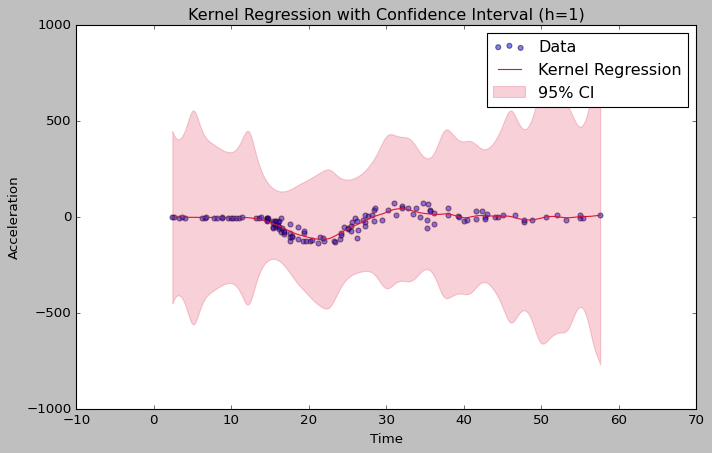

Effective degrees of freedom (trace S): 21.579


In [28]:
# Estimate residual variance
n = len(t_train)
residuals = a_train - kernel_regression(t_train, a_train, t_train, h)
sigma2_hat = np.sum(residuals**2) / (n - 2 * trace_S + trace_S)
sigma_hat = np.sqrt(sigma2_hat)

# Compute predictions and confidence bands
a_pred = []
se_pred = []

t_grid = np.linspace(t_train.min(), t_train.max(), 500)
m_hat = kernel_regression(t_train, a_train, t_grid, h)
z = norm.ppf(0.975)  # for 95% CI

density = np.array([p_hat(x, t_train, h) for x in t_grid])
ci_width = z * sigma_hat / np.sqrt(density)
ci_upper = m_hat + ci_width
ci_lower = m_hat - ci_width

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(t_train, a_train, alpha=0.5, label='Data')
plt.plot(t_grid, m_hat, color='crimson', label='Kernel Regression')
plt.fill_between(t_grid, ci_lower, ci_upper, color='crimson', alpha=0.2, label='95% CI')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title(f'Kernel Regression with Confidence Interval (h={h})')
plt.legend()
plt.show()

# Print degrees of freedom
print(f"Effective degrees of freedom (trace S): {trace_S:.3f}")

# 4) Local Linear Regression

In [29]:
import numpy as np
import matplotlib.pyplot as plt

t = df['times'].values
y = df['accel'].values

# Gaussian kernel
def gaussian_kernel(u):
    return np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)

# Local linear regression
def local_linear_regression(t_train, y_train, t_eval, h):
    y_pred = np.zeros_like(t_eval)

    for j, x0 in enumerate(t_eval):
        x = t_train - x0
        W = np.diag(gaussian_kernel(x / h))

        X = np.column_stack((np.ones_like(x), x))
        beta = np.linalg.pinv(X.T @ W @ X) @ X.T @ W @ y_train
        y_pred[j] = beta[0]  # intercept is the prediction at x0

    return y_pred

In [30]:
t_grid = np.linspace(t.min(), t.max(), 500)
h = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3]  

# Run kernel regression
for bandwidth in h:
    a_pred = local_linear_regression(t_train, a_train, t_grid, bandwidth)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_index, test_index in kf.split(t_train):
        X_train, X_test = t_train[train_index], t_train[test_index]
        y_train, y_test = a_train[train_index], a_train[test_index]

        # Make predictions on the test set using kernel regression
        y_pred = local_linear_regression(X_train, y_train, X_test, bandwidth)

        score = mean_squared_error(y_test, y_pred)
        scores.append(score)

    print(f"Bandwidth: {bandwidth}, Mean CV MSE: {np.mean(scores):.4f}")

Bandwidth: 0.25, Mean CV MSE: 859.2128
Bandwidth: 0.5, Mean CV MSE: 743.5568
Bandwidth: 0.75, Mean CV MSE: 676.0787
Bandwidth: 1, Mean CV MSE: 638.9331
Bandwidth: 1.25, Mean CV MSE: 618.4054
Bandwidth: 1.5, Mean CV MSE: 610.0070
Bandwidth: 1.75, Mean CV MSE: 613.0378
Bandwidth: 2, Mean CV MSE: 624.4726
Bandwidth: 2.5, Mean CV MSE: 672.4511
Bandwidth: 3, Mean CV MSE: 746.0805


### Using K-Fold CV, we have h=1.5 in local linear regression

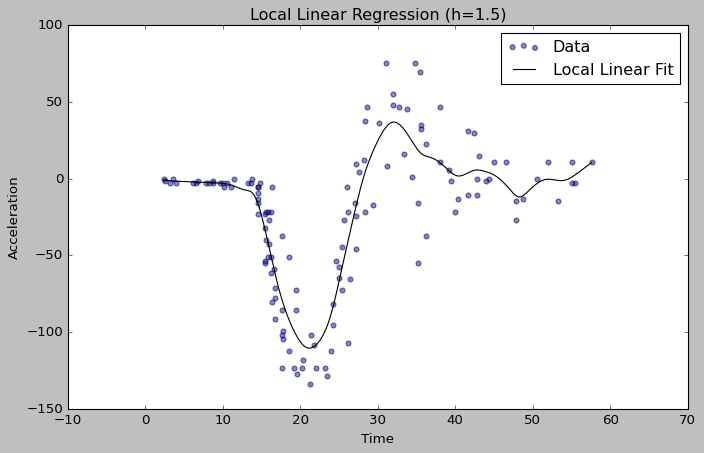

In [31]:
# Evaluation grid
t_grid = np.linspace(t.min(), t.max(), 500)
h = 1.5 


# Predict
y_fit = local_linear_regression(t, y, t_grid, h)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(t, y, alpha=0.5, label='Data')
plt.plot(t_grid, y_fit, color='black', label='Local Linear Fit')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title(f'Local Linear Regression (h={h})')
plt.legend()
plt.show()

### Degree of Freedom and Condifence interval

In [32]:
from scipy.stats import t

In [33]:
x = df['times'].values
y = df['accel'].values
n = len(x)

# Gaussian kernel
def gaussian_kernel(u):
    return np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)

# Local polynomial smoother (manual, degree=1 = local linear)
def lps_manual(x, y, deg=1, h=1.0, x_smooth=None):
    if x_smooth is None:
        x_smooth = np.linspace(np.min(x), np.max(x), 300)

    y_smooth_hat = []
    S_smooth_rows = []
    X0 = np.vander([0]*len(x), N=deg+1, increasing=True)  # e.g., [1, 0, 0^2] for deg=2

    for x0 in x_smooth:
        X = np.vander(x - x0, N=deg+1, increasing=True)
        W = np.diag(gaussian_kernel((x - x0)/h))

        XtWX_inv = np.linalg.pinv(X.T @ W @ X)
        S_row = X0[0] @ XtWX_inv @ X.T @ W  # 1 x n row for this x0
        y0_hat = S_row @ y

        y_smooth_hat.append(y0_hat)
        S_smooth_rows.append(S_row)

    S_smooth = np.vstack(S_smooth_rows)  # shape: (len(x_smooth), n)
    S = []  # smoother matrix for original data points
    y_hat = []
    for i in range(n):
        Xi = np.vander(x - x[i], N=deg+1, increasing=True)
        Wi = np.diag(gaussian_kernel((x - x[i])/h))
        XtWXi = np.linalg.pinv(Xi.T @ Wi @ Xi)
        Si = X0[0] @ XtWXi @ Xi.T @ Wi
        S.append(Si)
        y_hat.append(Si @ y)

    S = np.vstack(S)  # n x n
    return {
        "x_smooth": x_smooth,
        "y_smooth_hat": np.array(y_smooth_hat),
        "S_smooth": S_smooth,
        "y_hat": np.array(y_hat),
        "S": S
    }

In [34]:
def plot_lps(x, y, deg=1, h=1.0):
    lps = lps_manual(x, y, deg=deg, h=h)
    y_hat = lps['y_hat']
    S = lps['S']
    x_smooth = lps['x_smooth']
    y_smooth_hat = lps['y_smooth_hat']
    S_smooth = lps['S_smooth']

    # Degrees of freedom
    trace_S = np.trace(S)
    trace_SS = np.trace(S @ S.T)
    df_eff = 2 * trace_S - trace_SS

    # Variance estimate
    sample_var = np.sum((y - y_hat)**2) / (len(x) - df_eff)

    # Confidence intervals
    var_func = sample_var * np.sum(S_smooth**2, axis=1)
    CI_upper = y_smooth_hat + t.ppf(0.975, df=df_eff) * np.sqrt(var_func)
    CI_lower = y_smooth_hat - t.ppf(0.975, df=df_eff) * np.sqrt(var_func)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.5, label='Data')
    plt.plot(x_smooth, y_smooth_hat, color='black', label='Smoothed Fit')
    plt.plot(x_smooth, CI_upper, color='red', linestyle='--', label='95% CI')
    plt.plot(x_smooth, CI_lower, color='red', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.title(f'Local Polynomial Smoothing\nDegree = {deg}, h = {h}')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Effective degrees of freedom: {df_eff:.2f}")

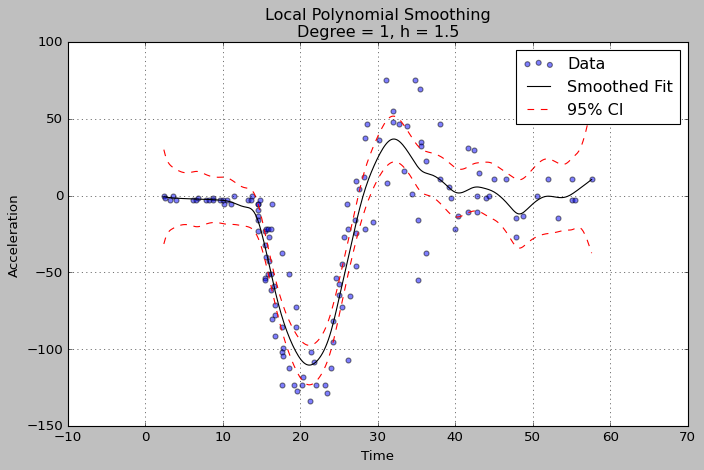

Effective degrees of freedom: 20.39


In [35]:
plot_lps(x, y, deg=1, h=1.5)

# 5) Regression splines with cubic B splines 

In [36]:
from patsy import dmatrix

In [48]:
x = df['times'].values
y = df['accel'].values

# 1. Choose knots (e.g. 5 interior quantiles)
knots = np.quantile(x, [0.1, 0.3, 0.5, 0.7, 0.9])

# 2. Create B-spline basis matrix
X = dmatrix("bs(x, knots=knots, degree=3, include_intercept=True)",
            {"x": x}, return_type='dataframe')
X = X.values  # convert to numpy array

# 3. Solve least squares: β = (XᵀX)⁻¹Xᵀy
beta = np.linalg.pinv(X.T @ X) @ X.T @ y
y_hat = X @ beta

# 4. Predict on a grid
x_grid = np.linspace(x.min(), x.max(), 500)
X_grid = dmatrix("bs(x, knots=knots, degree=3, include_intercept=True)",
                 {"x": x_grid}, return_type='dataframe').values
y_grid_hat = X_grid @ beta

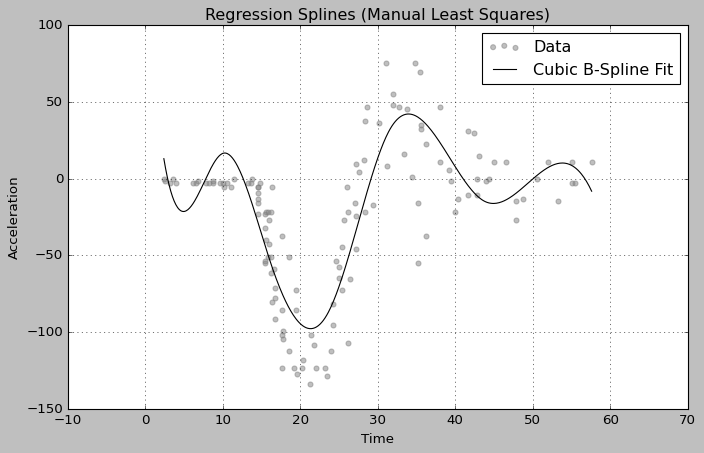

In [49]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='gray', alpha=0.5, label='Data')
plt.plot(x_grid, y_grid_hat, color='black', label='Cubic B-Spline Fit')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Regression Splines (Manual Least Squares)')
plt.legend()
plt.grid(True)
plt.show()

### $\text{DoF} = \operatorname{trace}(S), \quad \text{where } S = X(X^TX)^{-1}X^T$

Effective degrees of freedom: 9.00


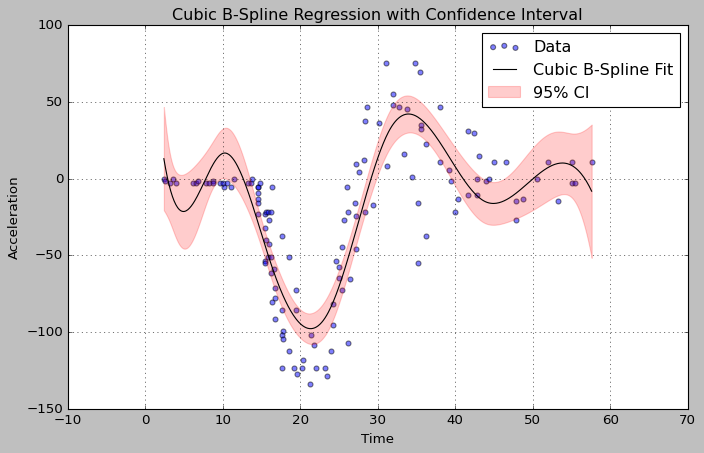

In [50]:
# Least squares solution
XtX_inv = np.linalg.pinv(X.T @ X)
beta = XtX_inv @ X.T @ y
y_hat = X @ beta

# Smoother matrix and DoF
S = X @ XtX_inv @ X.T
trace_S = np.trace(S)
print(f"Effective degrees of freedom: {trace_S:.2f}")

# Estimate residual variance
residuals = y - y_hat
sigma2_hat = np.sum(residuals**2) / (n - trace_S)
sigma_hat = np.sqrt(sigma2_hat)

# Predict on grid
x_grid = np.linspace(x.min(), x.max(), 500)
X_grid = dmatrix("bs(x, knots=knots, degree=3, include_intercept=True)",
                 {"x": x_grid}, return_type='dataframe').values
y_grid_hat = X_grid @ beta

# Confidence interval
se_grid = np.sqrt(np.sum((X_grid @ XtX_inv) * X_grid, axis=1)) * sigma_hat
z = t.ppf(0.975, df=n - trace_S)  # 95% CI
ci_upper = y_grid_hat + z * se_grid
ci_lower = y_grid_hat - z * se_grid

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, label='Data')
plt.plot(x_grid, y_grid_hat, color='black', label='Cubic B-Spline Fit')
plt.fill_between(x_grid, ci_lower, ci_upper, color='red', alpha=0.2, label='95% CI')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Cubic B-Spline Regression with Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()

# 6) Smoothing Splines

In [51]:
from scipy.interpolate import UnivariateSpline
from scipy.stats import t

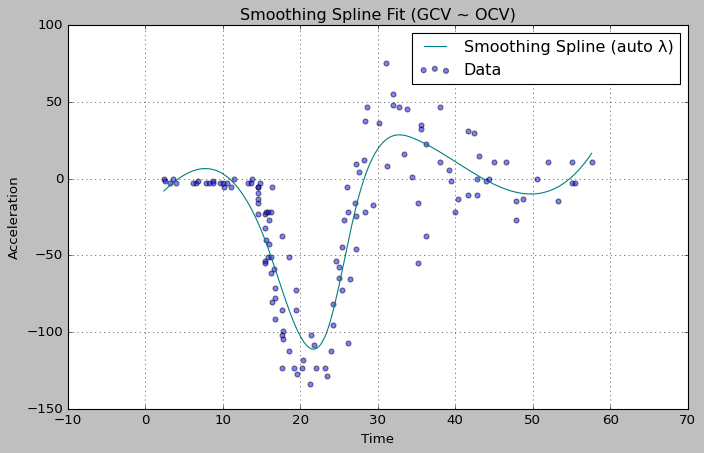

In [66]:
x = df['times'].values
y = df['accel'].values

# Sort x for spline fitting
sort_idx = np.argsort(x)
x_sorted = x[sort_idx]
y_sorted = y[sort_idx]

# Fit smoothing spline with automatic smoothing parameter (≈ OCV)
spline = UnivariateSpline(x_sorted, y_sorted, s=70000)

# Predict on dense grid
x_grid = np.linspace(x_sorted.min(), x_sorted.max(), 500)
y_grid = spline(x_grid)

x = df['times'].values
y = df['accel'].values

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_grid, y_grid, color='teal', label='Smoothing Spline (auto λ)')
plt.scatter(x, y, alpha = 0.5, label='Data')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Smoothing Spline Fit (GCV ~ OCV)')
plt.legend()
plt.grid(True)
plt.show()

Approximate DoF (trace(S)): 8.00


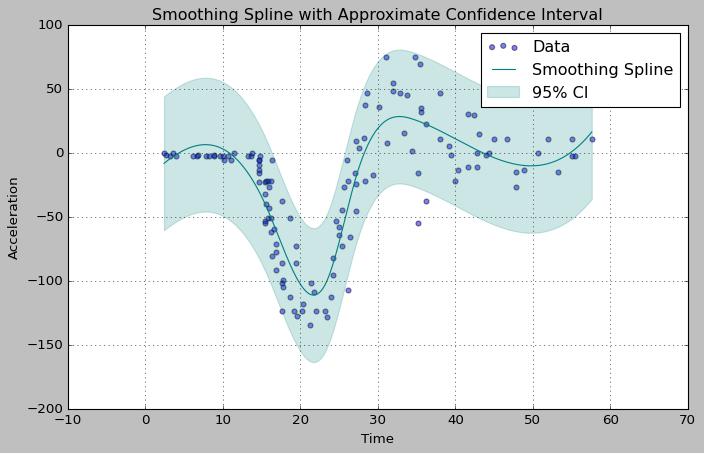

In [67]:
# Approximate effective DoF: number of nonzero spline coefficients
trace_S = np.sum(spline.get_coeffs() != 0)
print(f"Approximate DoF (trace(S)): {trace_S:.2f}")

# Estimate residual variance
sigma2_hat = np.sum(residuals**2) / (n - trace_S)
sigma_hat = np.sqrt(sigma2_hat)

# CI: assume constant SE for now
z = t.ppf(0.975, df=n - trace_S)
ci_upper = y_grid + z * sigma_hat
ci_lower = y_grid - z * sigma_hat

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, label='Data')
plt.plot(x_grid, y_grid, color='teal', label='Smoothing Spline')
plt.fill_between(x_grid, ci_lower, ci_upper, color='teal', alpha=0.2, label='95% CI')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Smoothing Spline with Approximate Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()

# 7) All Plots together

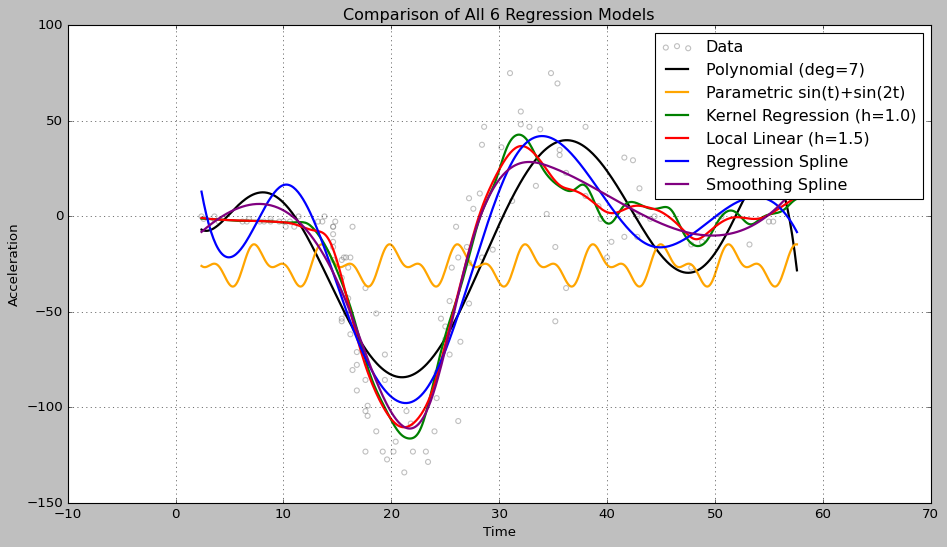

In [70]:
x = df['times'].values
y = df['accel'].values
n = len(x)
sort_idx = np.argsort(x)
x_sorted = x[sort_idx]
y_sorted = y[sort_idx]

x_grid = np.linspace(x.min(), x.max(), 500)

# === 1. Polynomial Regression (deg=7) ===
X_poly = np.vander(x, N=8, increasing=True)  # degree 7 → 8 columns
beta_poly = lstsq(X_poly, y, rcond=None)[0]
X_grid_poly = np.vander(x_grid, N=8, increasing=True)
y_poly = X_grid_poly @ beta_poly

# === 2. Parametric Trig Regression (a + b sin(t) + c sin(2t)) ===
X_trig = np.column_stack([np.ones_like(x), np.sin(x), np.sin(2*x)])
beta_trig = lstsq(X_trig, y, rcond=None)[0]
X_grid_trig = np.column_stack([np.ones_like(x_grid), np.sin(x_grid), np.sin(2*x_grid)])
y_trig = X_grid_trig @ beta_trig

# === 3. Kernel Regression ===
def gaussian_kernel(u): return np.exp(-0.5 * u**2) / np.sqrt(2*np.pi)
def kernel_regression(x_train, y_train, x_eval, h):
    preds = []
    for x0 in x_eval:
        w = gaussian_kernel((x0 - x_train) / h)
        preds.append(np.sum(w * y_train) / np.sum(w))
    return np.array(preds)
y_kernel = kernel_regression(x, y, x_grid, h=1.0)

# === 4. Local Linear Regression ===
def local_linear(x_train, y_train, x_eval, h):
    y_pred = []
    for x0 in x_eval:
        x_diff = x_train - x0
        W = np.diag(gaussian_kernel(x_diff / h))
        X = np.column_stack([np.ones_like(x_diff), x_diff])
        beta = np.linalg.pinv(X.T @ W @ X) @ (X.T @ W @ y_train)
        y_pred.append(beta[0])
    return np.array(y_pred)
y_ll = local_linear(x, y, x_grid, h=1.5)

# === 5. Regression Splines ===
knots = np.quantile(x, [0.1, 0.3, 0.5, 0.7, 0.9])
X_spline = dmatrix("bs(x, knots=knots, degree=3, include_intercept=True)", {"x": x}, return_type='dataframe').values
beta_spline = lstsq(X_spline, y, rcond=None)[0]
X_grid_spline = dmatrix("bs(x, knots=knots, degree=3, include_intercept=True)", {"x": x_grid}, return_type='dataframe').values
y_spline = X_grid_spline @ beta_spline

# === 6. Smoothing Spline ===
spline = UnivariateSpline(x_sorted, y_sorted, s=70000)
y_smooth_spline = spline(x_grid)

# === Plot All Fits ===
plt.figure(figsize=(12, 7))
plt.scatter(x, y, facecolors='none', edgecolors='gray', label='Data', alpha=0.5)

plt.plot(x_grid, y_poly, label='Polynomial (deg=7)', color='black', lw=2)
plt.plot(x_grid, y_trig, label='Parametric sin(t)+sin(2t)', color='orange', lw=2)
plt.plot(x_grid, y_kernel, label='Kernel Regression (h=1.0)', color='green', lw=2)
plt.plot(x_grid, y_ll, label='Local Linear (h=1.5)', color='red', lw=2)
plt.plot(x_grid, y_spline, label='Regression Spline', color='blue', lw=2)
plt.plot(x_grid, y_smooth_spline, label='Smoothing Spline', color='purple', lw=2)

plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Comparison of All 6 Regression Models')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Lets compare the models using K-Fold CV score

In [72]:
#K-Fold function
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def kfold_cv(x, y, model_fn, predict_fn, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    mse_list = []

    for train_idx, test_idx in kf.split(x):
        x_train, y_train = x[train_idx], y[train_idx]
        x_test, y_test = x[test_idx], y[test_idx]

        model = model_fn(x_train, y_train)
        y_pred = predict_fn(model, x_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_list.append(mse)

    return np.mean(mse_list)

In [75]:
# === 1. Polynomial Regression (deg=7) ===
def model_poly(x_train, y_train):
    X = np.vander(x_train, N=8, increasing=True)
    beta = lstsq(X, y_train, rcond=None)[0]
    return beta

def predict_poly(beta, x_test):
    X = np.vander(x_test, N=8, increasing=True)
    return X @ beta

# === 2. Parametric Trig Regression (a + b sin(t) + c sin(2t)) ===
def model_trig(x_train, y_train):
    X = np.column_stack([np.ones_like(x_train), np.sin(x_train), np.sin(2*x_train)])
    beta = lstsq(X, y_train, rcond=None)[0]
    return beta

def predict_trig(beta, x_test):
    X = np.column_stack([np.ones_like(x_test), np.sin(x_test), np.sin(2*x_test)])
    return X @ beta

# === 3. Kernel Regression ===
def model_kernel(x_train, y_train):
    return (x_train, y_train)

def predict_kernel(model, x_test):
    x_train, y_train = model
    return kernel_regression(x_train, y_train, x_test, h=1)

# === 4. Local Linear Regression ===
def model_ll(x_train, y_train):
    return (x_train, y_train)

def predict_ll(model, x_test):
    x_train, y_train = model
    return local_linear(x_train, y_train, x_test, h=1.5)

# === 5. Regression Splines ===
# FIXED: Define knots from training data and pass them to both functions
def model_spline(x_train, y_train):
    knots = np.quantile(x_train, [0.1, 0.3, 0.5, 0.7, 0.9])
    X = dmatrix("bs(x, knots=knots, degree=3, include_intercept=True)",
                {"x": x_train, "knots": knots}, return_type='dataframe').values
    beta = lstsq(X, y_train, rcond=None)[0]
    return beta, knots  # pass knots back

def predict_spline(model, x_test):
    beta, knots = model
    # Ensure knots and x_test are consistent
    x_min, x_max = x_test.min(), x_test.max()
    valid_knots = knots[(knots > x_min) & (knots < x_max)]

    # If valid_knots are empty (rare), fallback to no knots
    if len(valid_knots) == 0:
        formula = "bs(x, degree=3, include_intercept=True)"
        data_dict = {"x": x_test}
    else:
        formula = "bs(x, knots=knots, degree=3, include_intercept=True)"
        data_dict = {"x": x_test, "knots": valid_knots}

    X_test = dmatrix(formula, data_dict, return_type='dataframe').values

    # Pad or truncate beta if knot count mismatch (for safety)
    beta = beta[:X_test.shape[1]]
    return X_test @ beta

# === 6. Smoothing Spline ===
def model_smooth(x_train, y_train):
    sort_idx = np.argsort(x_train)
    return UnivariateSpline(x_train[sort_idx], y_train[sort_idx], s=70000)

def predict_smooth(model, x_test):
    return model(x_test)

In [76]:
x_np = df['times'].values
y_np = df['accel'].values

cv_scores = {
    "Polynomial (deg=7)": kfold_cv(x_np, y_np, model_poly, predict_poly),
    "Parametric sin(t)+sin(2t)": kfold_cv(x_np, y_np, model_trig, predict_trig),
    "Kernel Regression": kfold_cv(x_np, y_np, model_kernel, predict_kernel),
    "Local Linear": kfold_cv(x_np, y_np, model_ll, predict_ll),
    "Regression Spline": kfold_cv(x_np, y_np, model_spline, predict_spline),
    "Smoothing Spline": kfold_cv(x_np, y_np, model_smooth, predict_smooth)
}

In [77]:
print("\nK-Fold Cross-Validated MSE (K=10):")
for name, score in cv_scores.items():
    print(f"{name:30s}: {score:.2f}")


K-Fold Cross-Validated MSE (K=10):
Polynomial (deg=7)            : 1382.07
Parametric sin(t)+sin(2t)     : 2542.38
Kernel Regression             : 637.94
Local Linear                  : 610.01
Regression Spline             : 1668.96
Smoothing Spline              : 773.65


This shows that $\textbf{local linear regression with gaussian kernel}$ performs the best among these.